# IMPLEMENTACIÓN MODELO PREDICTIVO - CRUE

### **Guía para la Implementación del Modelo Predictivo Espaciotemporal**

## **Introducción**

Este notebook está diseñado como una guía práctica para implementar el modelo predictivo de demanda de servicios de emergencias médicas. Está orientado a usuarios del CRUE y no requiere conocimientos avanzados en programación o ciencia de datos.


## **1. Preparación del Entorno**

Antes de comenzar, asegúrese de tener los siguientes elementos:

1. Acceso a este notebook desde Google Colab.
2. El archivo CSV que contenga los datos necesarios, como incidentes históricos, variables climáticas, y demográficas.
3. Cuenta de Google conectada para guardar y cargar datos.

## **2. Librerías Necesarias**

Primero, se cargan las librerías que nos ayudarán a ejecutar el modelo.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import joblib
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from google.colab import drive, files

## **3. Cargar los Datos**

Cargaremos los datos históricos que utilizaremos para realizar las predicciones. Asegúrese de que el archivo esté correctamente cargado en su entorno de Colab.

In [ ]:
# Definir ruta del archivo
drive.mount('/content/drive')
# Subir el archivo CSV
Datos = pd.read_csv(f"/content/drive/MyDrive/Proyecto de grado/Datos_sds/datos_pred_julio.csv", delimiter=',', encoding='UTF-8')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Visualizar las primeras filas
Datos.head()

,cod_incidente,hora_fecha_inicial,Anio,Mes,Dia_mes,Infantes_0_4,Niños_5_14,Adolecentes_15_19,Adultos_20_59,Adultos_mayores_60,...,Inc_Paro,Aforo_total,ValorPrecip,Densidad_poblacional,prioridad.inicial_ALTA,prioridad.inicial_BAJA,prioridad.inicial_CRITICA,prioridad.inicial_MEDIA,Fecha,Festivo
0,CRU-0100000-24,7/1/2024 7:30,2024,7,1,513,1754,883,6402,1275,...,0,0,0.0,6.163392,1,0,0,0,7/1/2024 7:30,1
1,CRU-0100001-24,7/2/2024 9:30,2024,7,2,18477,38642,18896,187187,45890,...,0,500,0.0,243.957081,1,0,0,0,7/2/2024 9:30,0
2,CRU-0100002-24,7/3/2024 20:10,2024,7,3,17268,37452,19207,180612,44529,...,0,500,0.0,421.169848,1,0,0,0,7/3/2024 20:10,0
3,CRU-0100003-24,7/4/2024 22:10,2024,7,4,13624,28096,15523,148662,36908,...,0,300,0.0,116.168764,0,0,1,0,7/4/2024 22:10,0
4,CRU-0100004-24,7/5/2024 13:55,2024,7,5,9737,13528,7466,95666,29871,...,0,0,0.0,131.279514,0,0,1,0,7/5/2024 13:55,0


## **4. Preparación de los Datos**

El modelo necesita que los datos estén organizados y limpios. Este paso se encarga de preparar las columnas necesarias.

Incialmente se agrupan los datos por las variables fecha del incidente, código de UPL y rango de hora del incidente.

In [ ]:
df_agrupado = Datos.groupby(['Fecha', 'Cod_UPL', 'Rango_Hora']).agg(
    Total_Incidentes=('cod_incidente', lambda x: x.nunique()),
    Anio = ('Anio', 'max'),
    Mes = ('Mes', 'max'),
    Dia_mes = ('Dia_mes', 'max'),
    Dia_del_anio = ('dia_del_anio', 'max'),
    Dia_semana = ('dia_semana', 'max'),
    Festivo = ('Festivo', 'max'),
    Cantidad_Eventos = ('Cantidad Eventos', 'max'),
    Aforo_Total_Eventos = ('Aforo_total', 'max'),
    Precipitacion_mm = ('ValorPrecip', 'max'),
    Infantes_0_4 = ('Infantes_0_4', 'max'),
    Niños_5_14 = ('Niños_5_14', 'max'),
    Adolecentes_15_19 = ('Adolecentes_15_19', 'max'),
    Adultos_20_59 = ('Adultos_20_59', 'max'),
    Adultos_mayores_60 = ('Adultos_mayores_60', 'max'),
    Total_Mujeres = ('Total_Mujeres', 'max'),
    Total_Hombres = ('Total_Hombres', 'max'),
    Total_Pob = ('Total_pob_UPL', 'max'),
    Densidad_poblacional = ('Densidad_poblacional', 'max'),

    Broma=('Broma', 'sum'),
    Falsa_alarma =('Falsa_alarma', 'sum'),
    Atendido=('Atendido', 'sum'),
    Inc_Herido=('Inc_Herido', 'sum'),
    Inc_TrstM=('Inc_TrstM', 'sum'),
    Inc_Enfermo=('Inc_Enfermo', 'sum'),
    Inc_Convulsion=('Inc_Convulsion', 'sum'),
    Inc_Dif_Resp=('Inc_Dif_Resp', 'sum'),
    Inc_Paro = ('Inc_Paro', 'sum'),

    PI_Critica = ('prioridad.inicial_CRITICA', 'sum'),
    PI_Alta = ('prioridad.inicial_ALTA', 'sum'),
    PI_Media = ('prioridad.inicial_MEDIA', 'sum'),
    PI_Baja = ('prioridad.inicial_BAJA', 'sum')

).reset_index()

Se ordena el conjunto de datos por las variables de agrupación y se calculan los incidentes del día anterior.

In [ ]:
df_agrupado['Fecha'] = pd.to_datetime(df_agrupado['Fecha'])
df = df_agrupado.sort_values(by=['Fecha', 'Cod_UPL', 'Rango_Hora'])
df['Inc_dia_anterior'] = df.groupby(['Cod_UPL', 'Rango_Hora'])['Total_Incidentes'].shift(1)
df = df.dropna(subset=['Inc_dia_anterior'])

Se convierte el rango de horas en una variable binaria.

In [ ]:
df['Rango_Hora'] = np.where(df['Rango_Hora'] == '9am-9pm', 1, 0)

## **5. Cargar el Modelo Preentrenado**

El modelo ya ha sido entrenado previamente. Aquí cargaremos ese modelo para usarlo directamente.

In [ ]:
modelo_xgb = joblib.load('/content/drive/MyDrive/Proyecto de grado/Datos_sds/modelo_xgb.pkl')
print("Modelo cargado exitosamente")

Modelo cargado exitosamente


## **6. Realizar Predicciones**

Utilizaremos el modelo cargado para predecir la demanda en los próximos días.

In [ ]:
# Seleccionar las columnas necesarias para las predicciones
X = df[['Cod_UPL', 'Dia_semana', 'Dia_del_anio', 'Rango_Hora', 'Densidad_poblacional', 'Adultos_mayores_60', 'Infantes_0_4', 'Festivo', 'Cantidad_Eventos', 'Inc_Herido', 'Inc_dia_anterior', 'PI_Critica']]

In [ ]:
# Realizar predicciones
df['prediccion'] = modelo_xgb.predict(X)

In [60]:
# Visualizar resultados
df[['Fecha', 'Rango_Hora', 'prediccion']].head(5)

,Fecha,Rango_Hora,prediccion
15,2024-07-02 11:56:00,1,3.946150
36,2024-07-03 06:50:00,0,2.477051
37,2024-07-03 06:50:00,0,3.994012
38,2024-07-03 06:50:00,0,3.842230
28,2024-07-03 20:10:00,1,4.572076


## **7. Visualización de Resultados**

Generamos gráficos para mostrar las predicciones de manera visual y comprensible.


<Figure size 1000x400 with 0 Axes>

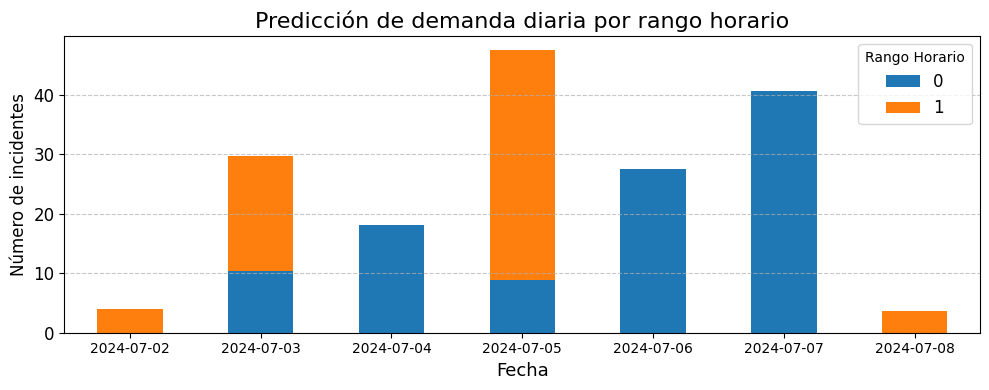

In [55]:
dia_hora = df.groupby([df['Fecha'].dt.date, 'Rango_Hora'])['prediccion'].sum().unstack()

plt.figure(figsize=(10, 4))
dia_hora.plot(kind='bar', stacked=True, figsize=(10, 4), color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.title('Predicción de demanda diaria por rango horario', fontsize=16)
plt.xlabel('Fecha', fontsize=13)
plt.ylabel('Número de incidentes', fontsize=12)
plt.legend(title='Rango Horario', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

*Nota*: Rango horario = 1 corresponde al periodo de 9AM a 9PM.\
       Rango horario = 0 corresponde al periodo de 9PM a 9AM.

## **8. Exportar Resultados**

Finalmente, exportaremos los resultados a un archivo CSV que puede usarse para la planificación.

In [61]:
output_file = 'predicciones.csv'
df.to_csv(output_file, index=False)

# **Conclusión**

Esta guía ha mostrado cómo usar el modelo predictivo para estimar la demanda de emergencias médicas. Con estas predicciones, podrá tomar decisiones informadas y optimizar los recursos del CRUE.

¡Buena suerte!
